In [212]:
import pandas as pd
import numpy as np

In [307]:
df = pd.read_csv('raw data/reddit_wsb.csv')
df.shape

(53187, 8)

In [313]:
df = pd.read_csv('reddit_sentiment_gemini_v2.csv')
df.shape

(172032, 8)

### Derive indicators
* Engagement ratio = Number of comments / Score

In [300]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# Set multiple index for date and stock
df = df.set_index(['date', 'stock'])
# Add up sentiment score of title and body
df['total_sentiment'] = df['title_sentiment'] + df['body_sentiment']
df = df.groupby(['date', 'stock']).agg('sum')
# Set score to 1 if it is less than 1
df['score'] = np.where(df['score'] < 1, 1, df['score'])
# Add column engagement_ratio
df['engagement_ratio'] = df['comms_num'] / df['score']
# Convert date string to datetime format
df = df.reset_index()
df = df.set_index(['date', 'stock'])

### Aggregate Monthly and calculate average sentiment for the month
#### Filter strategy
* Top 5 "Sentiment" stocks (Not good in return (22-Apr done)
* Top 5 "Engagement" stocks (Return similar to QQQ in the beginning, then became loss) (27-Apr done)

In [216]:
df

title  score  \
date       stock                                                             
2020-09-29 CBAT   $CBAT $SUNW $SPI $OXBR Y'all are missing the p...   24.0   
           OXBR   $CBAT $SUNW $SPI $OXBR Y'all are missing the p...   12.0   
           SPI    $CBAT $SUNW $SPI $OXBR Y'all are missing the p...   12.0   
           SUNW   $CBAT $SUNW $SPI $OXBR Y'all are missing the p...   12.0   
2021-01-28 AHT    $AHT!!!! LETS GOOOOO $AHT!!!$AHT!!!! LETS GOOO...    1.0   
...                                                             ...    ...   
2021-08-16 TGT    Historical Post Earnings Moves MEGA Compilatio...  645.0   
           UPST   Historical Post Earnings Moves MEGA Compilatio...  645.0   
           VZ     Verizon ($VZ) – Boomer’s Dividends Are Degener...   39.0   
           WMT    Historical Post Earnings Moves MEGA Compilatio...  645.0   
           ZETA    ZETA global holdings… DDZETA global holdings… DD    1.0   

                  comms_num  \
date       stock              
2020-09-29 CBAT        66.0   
           OXBR        33.0   
           SPI         33.0   
           SUNW        33.0   
2021-01-28 AHT          4.0   
...                     ...   
2021-08-16 TGT        225.0   
           UPST       225.0   
           VZ          51.0   
           WMT        225.0   
           ZETA        22.0   

                                                               body  \
date       stock                                                      
2020-09-29 CBAT   $CBAT is going to be a great play further yet:...   
           OXBR   $CBAT is going to be a great play further yet:...   
           SPI    $CBAT is going to be a great play further yet:...   
           SUNW   $CBAT is going to be a great play further yet:...   
2021-01-28 AHT    $AHT!!!! LETS GOOOOO $AHT!!!$AHT!!!! LETS GOOO...   
...                                                             ...   
2021-08-16 TGT    **Historical Post Earnings Moves MEGA Compilat...   
           UPST   **Historical Post Earnings Moves MEGA Compilat...   
           VZ     My wife decided to go to her boyfriend’s house...   
           WMT    **Historical Post Earnings Moves MEGA Compilat...   
           ZETA   Ok degenerates – I’d like to introduce you to ...   

                  title_sentiment  body_sentiment  total_sentiment  \
date       stock                                                     
2020-09-29 CBAT               0.0             0.0              0.0   
           OXBR               0.0             0.0              0.0   
           SPI                0.0             0.0              0.0   
           SUNW               0.0             0.0              0.0   
2021-01-28 AHT                2.0             2.0              4.0   
...                           ...             ...              ...   
2021-08-16 TGT               15.0            15.0             30.0   
           UPST              15.0            15.0             30.0   
           VZ                 6.0             6.0             12.0   
           WMT               15.0            15.0             30.0   
           ZETA               2.0             2.0              4.0   

                  engagement_ratio  
date       stock                    
2020-09-29 CBAT           2.750000  
           OXBR           2.750000  
           SPI            2.750000  
           SUNW           2.750000  
2021-01-28 AHT            4.000000  
...                            ...  
2021-08-16 TGT            0.348837  
           UPST           0.348837  
           VZ             1.307692  
           WMT            0.348837  
           ZETA          22.000000  

[12418 rows x 8 columns]

In [289]:
# Filter strategy
indicator = 'comms_num'
# Aggregate monthly engagement
df_engagement = (df.reset_index('stock').groupby([pd.Grouper(freq='ME'), 'stock'])[[indicator]].mean())
# Rank based on specific indicator
df_engagement['rank'] = (df_engagement.groupby(level=0)[indicator].transform(lambda x: x.rank(ascending=False).astype(int)))
# Filter out top 5 ranking
df_filtered = df_engagement[df_engagement['rank'] < 6].copy()
# Adjust date to be the first day of the month
df_filtered = df_filtered.reset_index('stock')
df_filtered.index = df_filtered.index + pd.DateOffset(1)
df_filtered = df_filtered.reset_index().set_index(['date', 'stock'])

### Extract the stocks to form portfolios with at the start of each new month
* Create a dictionary containing start of month and corresponded selected stocks.

In [290]:
# Get all dates from each date index
dates = df_filtered.index.get_level_values('date').unique().to_list()
# List all stocks for each date
fixed_dates = {}
for date in dates:
  fixed_dates[date.strftime('%Y-%m-%d')] = df_filtered.xs(date, level=0).index.tolist()

fixed_dates

{'2020-10-01': ['CBAT', 'OXBR', 'SPI', 'SUNW'],
 '2021-02-01': ['AMC', 'BB', 'DIS', 'GME', 'TSLA'],
 '2021-03-01': ['AMC', 'CRLBF', 'GME', 'HUGE', 'USO'],
 '2021-04-01': ['ALKS', 'AMAT', 'BLKB', 'FCX', 'GME', 'LEA', 'RKT'],
 '2021-05-01': ['ANF', 'AVIS', 'GME', 'XRAY'],
 '2021-06-01': ['ROOT', 'RTX'],
 '2021-07-01': ['AMC', 'BB', 'CLNE', 'CLOV', 'GME'],
 '2021-08-01': ['AMC', 'CLOV', 'GME', 'NKE', 'SDOW'],
 '2021-09-01': ['CLOV', 'MVST']}

### Download the fresh stock prices for only selected/shortlisted stocks
* Calculate cumulative log returns (Time-additive)

In [291]:
# List all wanted stocks
stock_list = df_filtered.index.get_level_values('stock').unique().to_list()

In [292]:
# import yfinance as yf
# start = pd.to_datetime(list(fixed_dates.keys())[0])
start = pd.to_datetime("2021-03-01")
start = start.strftime('%Y-%m-%d')
# end = pd.to_datetime(list(fixed_dates.keys())[-1])
end = pd.to_datetime("2021-08-31")
end = end.strftime('%Y-%m-%d')
# import yfinance as yf
# df_all = yf.download(tickers=stock_list,
#             start=start,
#             end=end)
#--------------------TRY USING PRE-DOWNLOADED LOCAL DATA-------------------------------------------
# Load data from csv instead of downloading
df_all = pd.DataFrame()
for ticker in stock_list:
    try:
        df_temp = pd.read_csv(f'stock_historical_prices_2019-2024/{ticker}.csv').set_index('Price')[start:end]['Close'].to_frame(ticker)
    except:
        print(f'Error reading {ticker}.csv')
        # If df_temp cannot be read, let the ticker be NaN
        df_temp = pd.DataFrame(index=pd.date_range(start, end), columns=[ticker])
        df_temp[ticker] = np.nan
    df_all = pd.concat([df_all, df_temp], axis=1)
df_return = np.log(df_all.astype('float64')).diff().dropna(how='all')


Error reading SPI.csv
Error reading SUNW.csv
Error reading CRLBF.csv
Error reading HUGE.csv
Error reading USO.csv
Error reading AVIS.csv
Error reading SDOW.csv


In [293]:
# Calculate log return of each stocks
# df_return = np.log(df_price['Close']).diff().dropna(how='all')

In [294]:
# Calculate portfolio return
df_portfolio = pd.DataFrame()
for start_date in fixed_dates.keys():
    # Find next month end as end date
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    # print(start_date, end_date)
    tickers = fixed_dates[start_date]
    # print(tickers)
    df_temp = df_return[start_date:end_date][tickers].mean(axis=1).to_frame('portfolio_return')
    # print(df_temp)
    df_portfolio = pd.concat([df_portfolio, df_temp], axis=0)
    
df_portfolio.index = pd.to_datetime(df_portfolio.index)

### Download prices of NASDAQ / QQQ and calculate returns to compare to our strategy

In [295]:
df_qqq = pd.read_csv('market_indexes_2019-2024/QQQ.csv').set_index('Price')[start:end]
df_qqq = df_qqq.astype('float64')
df_qqq.index = pd.to_datetime(df_qqq.index)
return_qqq = np.log(df_qqq['Close']).diff().dropna()
return_qqq.name = 'QQQ'

In [296]:
df_return_portfolio = df_portfolio.merge(return_qqq,
                                  left_index=True,
                                  right_index=True)

In [297]:
df_return_portfolio

,portfolio_return,QQQ
2021-03-02,-0.023111,-0.016169
2021-03-03,0.004770,-0.029450
2021-03-04,-0.001266,-0.016502
2021-03-05,0.021203,0.014949
2021-03-08,0.244165,-0.028723
...,...,...
2021-08-25,-0.020269,0.001148
2021-08-26,-0.026096,-0.006370
2021-08-27,0.007844,0.009673
2021-08-30,0.016794,0.011160


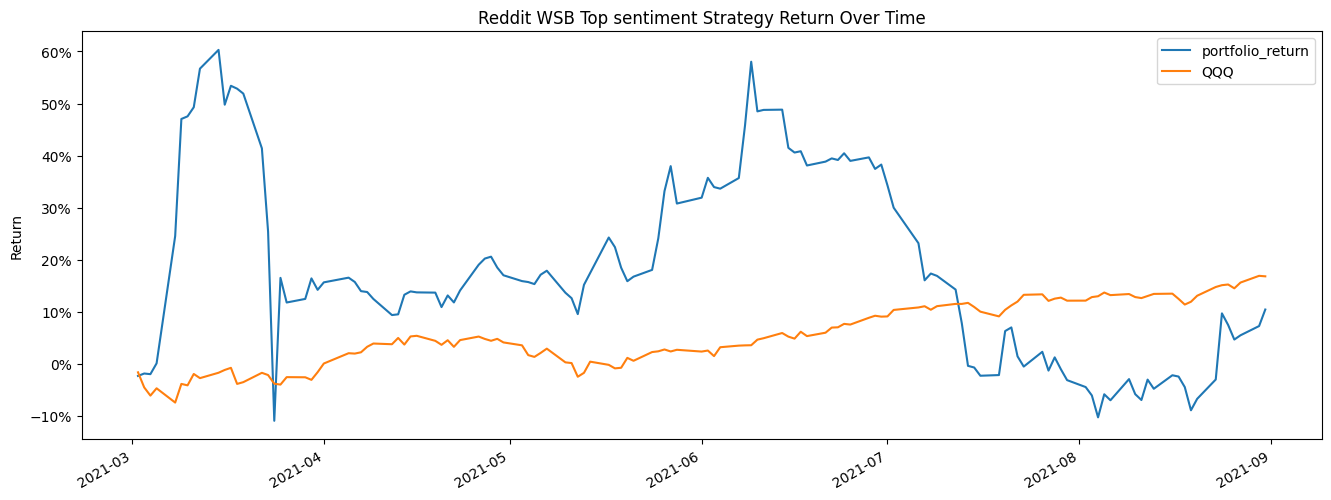

In [298]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
portfolio_cumulative_return = np.exp(np.log1p(df_return_portfolio).cumsum()).sub(1)

portfolio_cumulative_return.plot(figsize=(16, 6))
plt.title('Reddit WSB Top sentiment Strategy Return Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()